In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
prem = pd.read_csv('../data/cleaned/cleanedprem.csv')
prem.head(1)

,MatchID,Season,MatchWeek,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,FullTimeResult,...,AwayTeamFouls,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards,HomeTeamPoints,AwayTeamPoints,year,month,day
0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,A,...,NaN,NaN,NaN,NaN,NaN,0,3,1993,8,14


In [33]:
def build_team_stats(df, season, games_played=38):
    season_df = df[df['Season'] == season].copy()

    # Home stats
    home = season_df.groupby('HomeTeam').agg(
        GF_H=('FullTimeHomeTeamGoals', 'sum'),
        GA_H=('FullTimeAwayTeamGoals', 'sum'),
        Shots_H=('HomeTeamShots', 'sum'),
        ShotsConceded_H=('AwayTeamShots', 'sum'),
        Wins_H=('FullTimeResult', lambda x: (x == 'H').sum()),
        Draws_H=('FullTimeResult', lambda x: (x == 'D').sum()),
        Losses_H=('FullTimeResult', lambda x: (x == 'A').sum())
    )

    # Away stats
    away = season_df.groupby('AwayTeam').agg(
        GF_A=('FullTimeAwayTeamGoals', 'sum'),
        GA_A=('FullTimeHomeTeamGoals', 'sum'),
        Shots_A=('AwayTeamShots', 'sum'),
        ShotsConceded_A=('HomeTeamShots', 'sum'),
        Wins_A=('FullTimeResult', lambda x: (x == 'A').sum()),
        Draws_A=('FullTimeResult', lambda x: (x == 'D').sum()),
        Losses_A=('FullTimeResult', lambda x: (x == 'H').sum())
    )

    # Combine
    team_stats = home.add(away, fill_value=0)

    # Add total stats
    team_stats['Wins'] = team_stats['Wins_H'] + team_stats['Wins_A']
    team_stats['Draws'] = team_stats['Draws_H'] + team_stats['Draws_A']
    team_stats['Losses'] = team_stats['Losses_H'] + team_stats['Losses_A']
    team_stats['Points'] = team_stats['Wins'] * 3 + team_stats['Draws']

    team_stats['GoalsScored'] = team_stats['GF_H'] + team_stats['GF_A']
    team_stats['GoalsConceded'] = team_stats['GA_H'] + team_stats['GA_A']
    team_stats['GoalDifference'] = team_stats['GoalsScored'] - team_stats['GoalsConceded']

    team_stats['ShotsTaken'] = team_stats['Shots_H'] + team_stats['Shots_A']
    team_stats['ShotsConceded'] = team_stats['ShotsConceded_H'] + team_stats['ShotsConceded_A']

    # Averages
    team_stats['AvgGoalsScored'] = team_stats['GoalsScored'] / games_played
    team_stats['AvgGoalsConceded'] = team_stats['GoalsConceded'] / games_played
    team_stats['AvgShotsTaken'] = team_stats['ShotsTaken'] / games_played
    team_stats['AvgShotsConceded'] = team_stats['ShotsConceded'] / games_played

    # Records
    team_stats['HomeRecord'] = (
        team_stats['Wins_H'].astype(int).astype(str) + '-' +
        team_stats['Draws_H'].astype(int).astype(str) + '-' +
        team_stats['Losses_H'].astype(int).astype(str)
    )
    team_stats['AwayRecord'] = (
        team_stats['Wins_A'].astype(int).astype(str) + '-' +
        team_stats['Draws_A'].astype(int).astype(str) + '-' +
        team_stats['Losses_A'].astype(int).astype(str)
    )

    # Final selection
    prem_table = team_stats[[
        'Points', 'Wins', 'Draws', 'Losses',
        'GoalsScored', 'GoalsConceded', 'GoalDifference',
        'ShotsTaken', 'ShotsConceded',
        'AvgGoalsScored', 'AvgGoalsConceded',
        'AvgShotsTaken', 'AvgShotsConceded',
        'HomeRecord', 'AwayRecord'
    ]].sort_values(by='Points', ascending=False).copy()

    return prem_table

In [41]:
seasons = [
    '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020',
    '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025'
]

# Create a dictionary of season tables
season_tables = {season: build_team_stats(prem, season) for season in seasons}

# Extract Man United data across selected seasons for comparison
manu_summary = pd.DataFrame({
    season: season_tables[season].loc['Man United']
    for season in seasons if 'Man United' in season_tables[season].index
}).T

manu_summary

,Points,Wins,Draws,Losses,GoalsScored,GoalsConceded,GoalDifference,ShotsTaken,ShotsConceded,AvgGoalsScored,AvgGoalsConceded,AvgShotsTaken,AvgShotsConceded,HomeRecord,AwayRecord
2013-2014,64.0,19.0,7.0,12.0,64.0,43.0,21.0,525.0,451.0,1.684211,1.131579,13.815789,11.868421,9-3-7,10-4-5
2014-2015,70.0,20.0,10.0,8.0,62.0,37.0,25.0,509.0,379.0,1.631579,0.973684,13.394737,9.973684,14-2-3,6-8-5
2015-2016,66.0,19.0,9.0,10.0,49.0,35.0,14.0,430.0,411.0,1.289474,0.921053,11.315789,10.815789,12-5-2,7-4-8
2016-2017,69.0,18.0,15.0,5.0,54.0,29.0,25.0,589.0,358.0,1.421053,0.763158,15.5,9.421053,8-10-1,10-5-4
2017-2018,81.0,25.0,6.0,7.0,68.0,28.0,40.0,513.0,436.0,1.789474,0.736842,13.5,11.473684,15-2-2,10-4-5
2018-2019,66.0,19.0,9.0,10.0,65.0,54.0,11.0,526.0,493.0,1.710526,1.421053,13.842105,12.973684,10-6-3,9-3-7
2019-2020,66.0,18.0,12.0,8.0,66.0,36.0,30.0,543.0,387.0,1.736842,0.947368,14.289474,10.184211,10-7-2,8-5-6
2020-2021,74.0,21.0,11.0,6.0,73.0,44.0,29.0,521.0,418.0,1.921053,1.157895,13.710526,11.0,9-4-6,12-7-0
2021-2022,58.0,16.0,10.0,12.0,57.0,57.0,0.0,508.0,511.0,1.5,1.5,13.368421,13.447368,10-5-4,6-5-8
2022-2023,75.0,23.0,6.0,9.0,58.0,43.0,15.0,592.0,481.0,1.526316,1.131579,15.578947,12.657895,15-3-1,8-3-8


In [46]:
manu_summary = manu_summary.reset_index().rename(columns={'index': 'Season'})

In [47]:
cols = ['Season'] + [col for col in manu_summary.columns if col != 'Season']
manu_summary = manu_summary[cols]

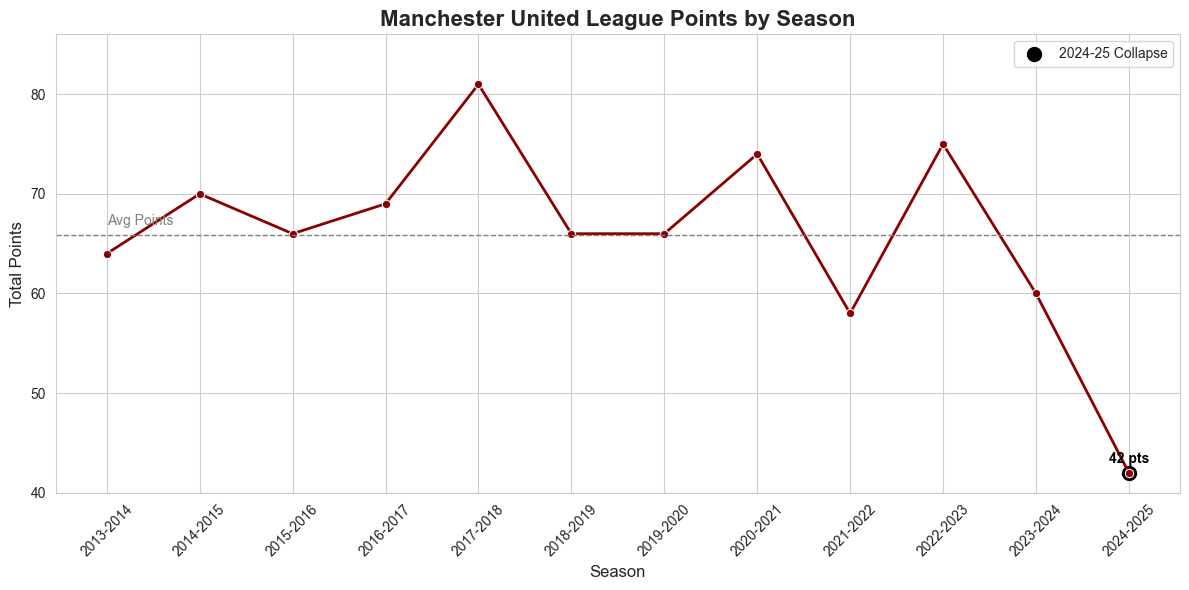

In [49]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Line plot
sns.lineplot(data=manu_summary, x='Season', y='Points', marker='o', color='darkred', linewidth=2)

# Highlight 2024-2025
last_season = manu_summary[manu_summary['Season'] == '2024-2025']
plt.scatter(last_season['Season'], last_season['Points'], color='black', s=100, label='2024-25 Collapse')

# Labels and title
plt.title("Manchester United League Points by Season", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(40, manu_summary['Points'].max() + 5)

# Annotate the lowest point
plt.text('2024-2025', last_season['Points'].values[0] + 1, "42 pts", color='black', ha='center', fontweight='bold')

# Optional mean line
plt.axhline(manu_summary['Points'].mean(), color='gray', linestyle='--', linewidth=1)
plt.text('2013-2014', manu_summary['Points'].mean() + 1, 'Avg Points', color='gray')

plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Reshape the DataFrame for seaborn
wdl_df = manu_summary[['Season', 'Wins', 'Draws', 'Losses']].melt(id_vars='Season', 
                                                                value_vars=['Wins', 'Draws', 'Losses'],
                                                                var_name='Result', 
                                                                value_name='Count')

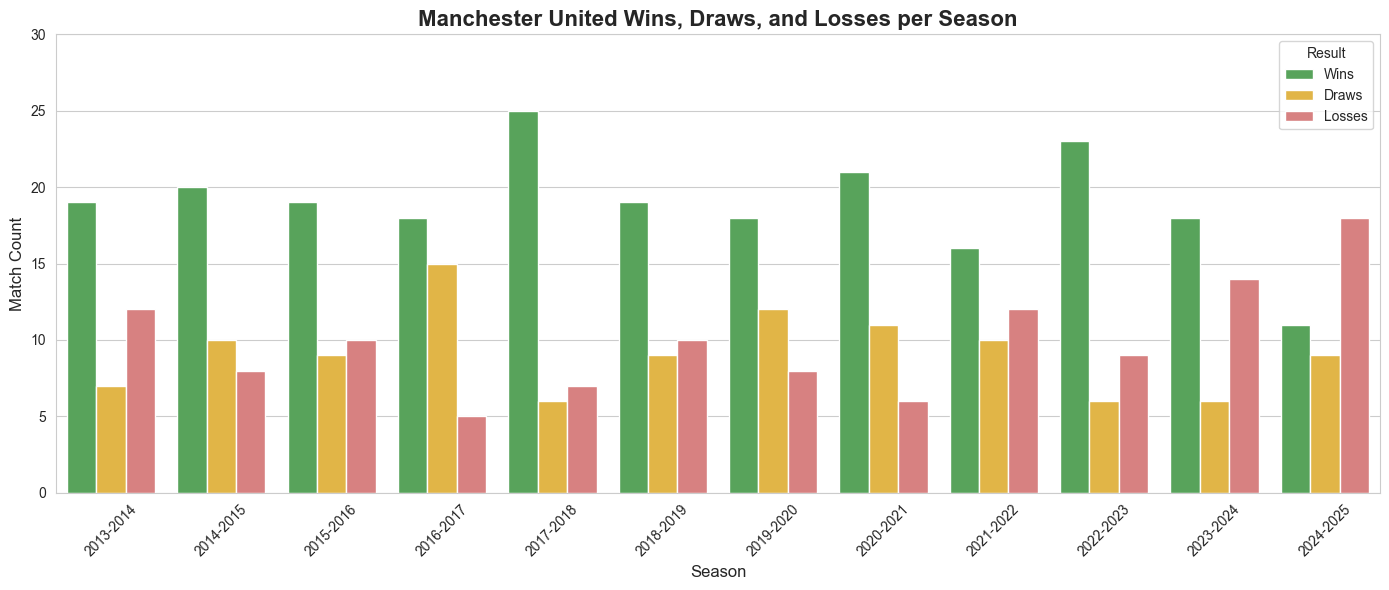

In [52]:
# Define a custom, softer color palette
custom_palette = {
    'Wins': '#4CAF50',      # soft green
    'Draws': '#FBC02D',     # muted yellow
    'Losses': '#E57373'     # soft red
}

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Create grouped barplot
sns.barplot(
    data=wdl_df, 
    x='Season', 
    y='Count', 
    hue='Result', 
    palette=custom_palette
)

# Title and labels
plt.title("Manchester United Wins, Draws, and Losses per Season", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Match Count", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 30)

plt.legend(title='Result', loc='upper right')
plt.tight_layout()
plt.show()

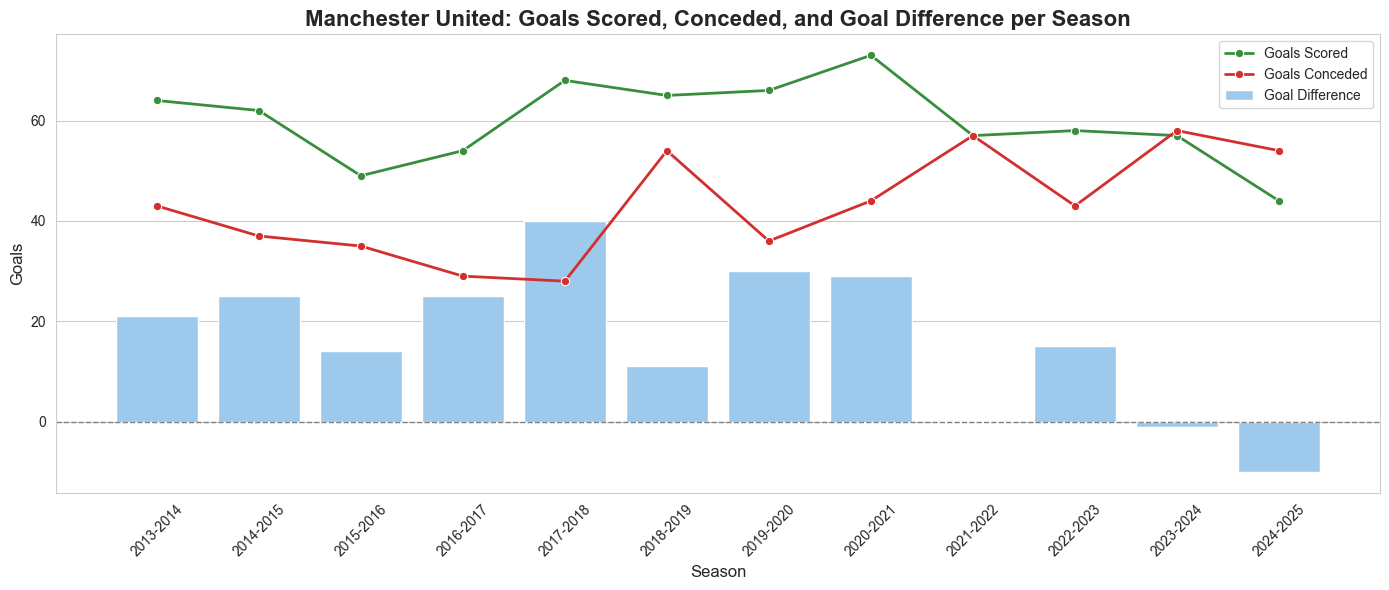

In [53]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Barplot: Goal Difference
sns.barplot(data=manu_summary, x='Season', y='GoalDifference', color='#90CAF9', label='Goal Difference')

# Lineplot: Goals Scored
sns.lineplot(data=manu_summary, x='Season', y='GoalsScored', marker='o', color='#388E3C', linewidth=2, label='Goals Scored')

# Lineplot: Goals Conceded
sns.lineplot(data=manu_summary, x='Season', y='GoalsConceded', marker='o', color='#D32F2F', linewidth=2, label='Goals Conceded')

# Titles and axes
plt.title("Manchester United: Goals Scored, Conceded, and Goal Difference per Season", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Goals", fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

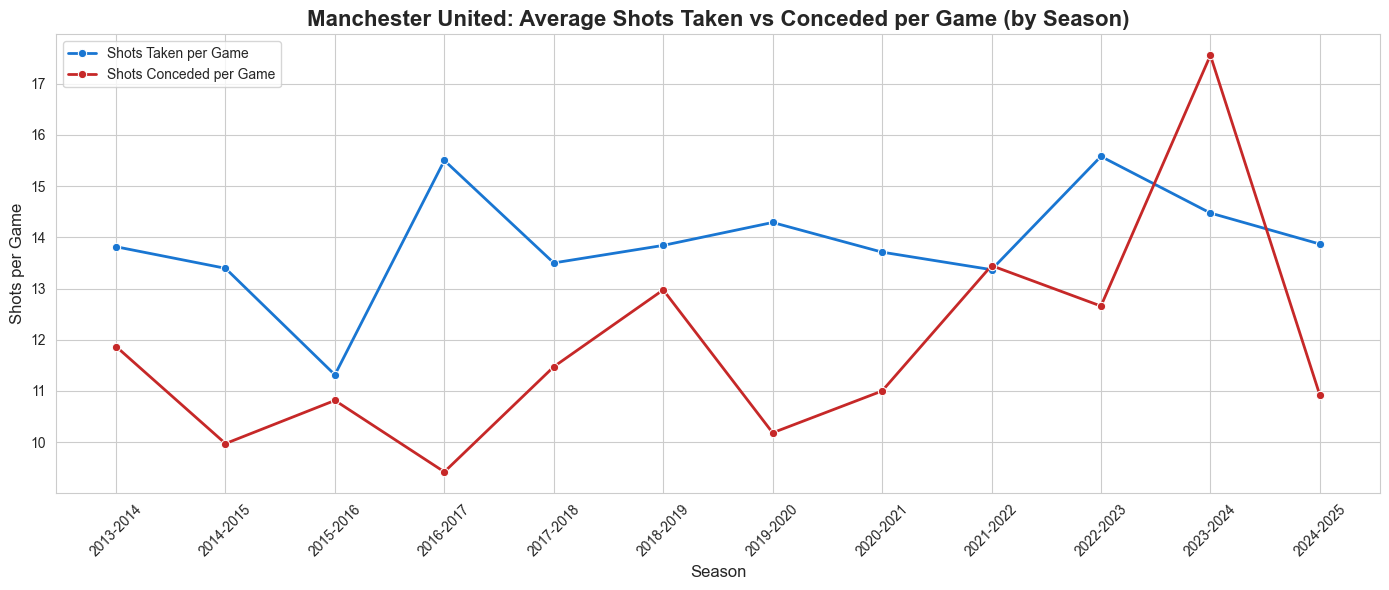

In [54]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Line: Shots Taken per Game
sns.lineplot(
    data=manu_summary, 
    x='Season', 
    y='AvgShotsTaken', 
    marker='o', 
    color='#1976D2', 
    linewidth=2, 
    label='Shots Taken per Game'
)

# Line: Shots Conceded per Game
sns.lineplot(
    data=manu_summary, 
    x='Season', 
    y='AvgShotsConceded', 
    marker='o', 
    color='#C62828', 
    linewidth=2, 
    label='Shots Conceded per Game'
)

# Labels and title
plt.title("Manchester United: Average Shots Taken vs Conceded per Game (by Season)", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Shots per Game", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

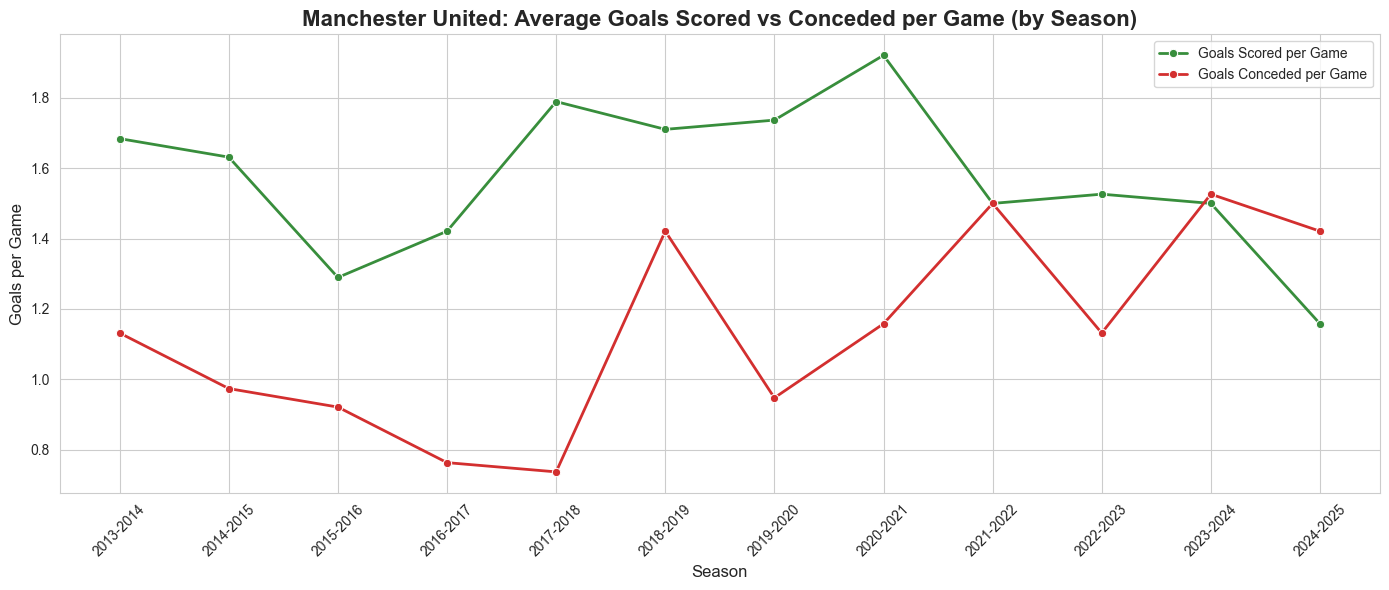

In [55]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Line: Avg Goals Scored per Game
sns.lineplot(
    data=manu_summary,
    x='Season',
    y='AvgGoalsScored',
    marker='o',
    color='#388E3C',
    linewidth=2,
    label='Goals Scored per Game'
)

# Line: Avg Goals Conceded per Game
sns.lineplot(
    data=manu_summary,
    x='Season',
    y='AvgGoalsConceded',
    marker='o',
    color='#D32F2F',
    linewidth=2,
    label='Goals Conceded per Game'
)

# Labels and title
plt.title("Manchester United: Average Goals Scored vs Conceded per Game (by Season)", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Goals per Game", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
manu_summary['ConversionRate_For'] = manu_summary['GoalsScored'] / manu_summary['ShotsTaken']
manu_summary['ConversionRate_Against'] = manu_summary['GoalsConceded'] / manu_summary['ShotsConceded']

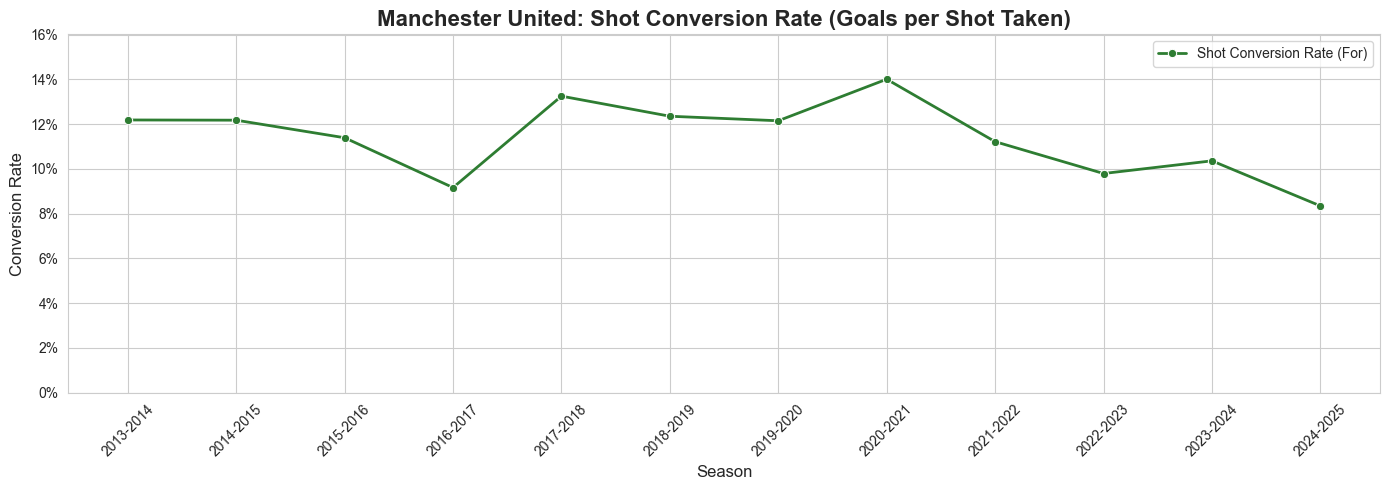

In [57]:
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

sns.lineplot(
    data=manu_summary,
    x='Season',
    y='ConversionRate_For',
    marker='o',
    color='#2E7D32',
    linewidth=2,
    label='Shot Conversion Rate (For)'
)

plt.title("Manchester United: Shot Conversion Rate (Goals per Shot Taken)", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Conversion Rate", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, manu_summary['ConversionRate_For'].max() + 0.02)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

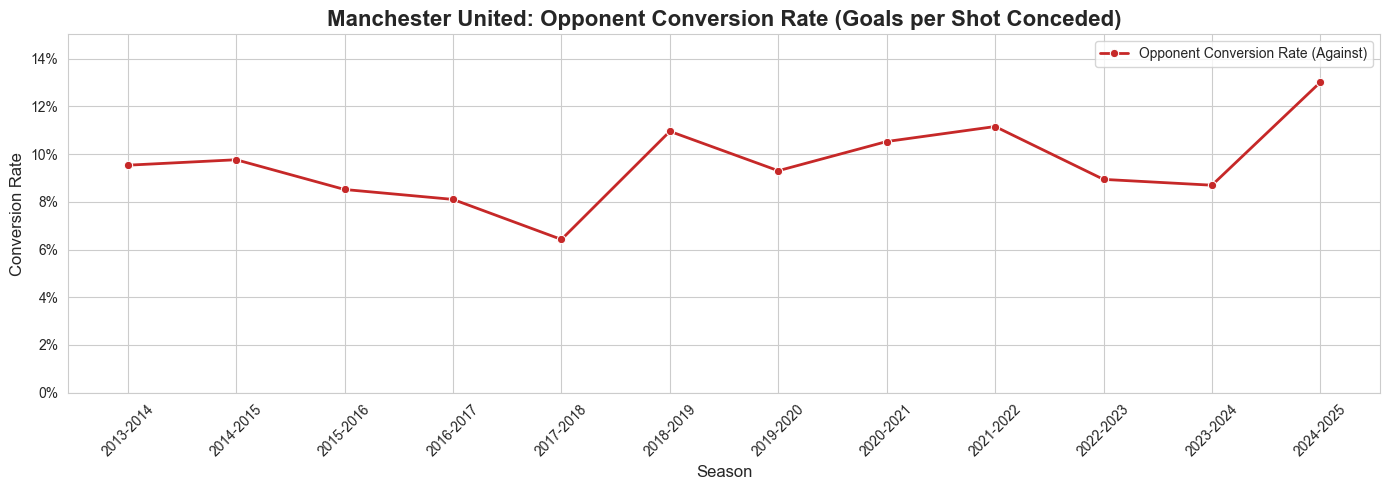

In [58]:
plt.figure(figsize=(14, 5))
sns.set_style("whitegrid")

sns.lineplot(
    data=manu_summary,
    x='Season',
    y='ConversionRate_Against',
    marker='o',
    color='#C62828',
    linewidth=2,
    label='Opponent Conversion Rate (Against)'
)

plt.title("Manchester United: Opponent Conversion Rate (Goals per Shot Conceded)", fontsize=16, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Conversion Rate", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, manu_summary['ConversionRate_Against'].max() + 0.02)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()